In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

df = pd.read_csv('/Churn_Modelling - Churn_Modelling.csv')

In [16]:
if df.CustomerId.nunique() == len(df):
  df.set_index('CustomerId',inplace=True)

In [17]:
df.drop(columns=['Surname','RowNumber'], inplace=True)

In [19]:
cat1 = [x for x in df.columns if str(df[x].dtype) == 'object']
ints = [x for x in df.columns if str(df[x].dtype) == 'int64'and df[x].nunique() > 5]
floats = [x for x in df.columns if str(df[x].dtype) == 'float64']
cat2 = [x for x in df.columns if df[x].nunique() <=5  and str(df[x].dtype) != 'object']
cols = [cat1,ints,floats,cat2]

In [20]:
for i in cols:
  print(df[i].describe().T)

           count unique     top  freq
Geography  10000      3  France  5014
Gender     10000      2    Male  5457
               count      mean        std    min    25%    50%    75%    max
CreditScore  10000.0  650.5288  96.653299  350.0  584.0  652.0  718.0  850.0
Age          10000.0   38.9218  10.487806   18.0   32.0   37.0   44.0   92.0
Tenure       10000.0    5.0128   2.892174    0.0    3.0    5.0    7.0   10.0
                   count           mean           std    min       25%  \
Balance          10000.0   76485.889288  62397.405202   0.00      0.00   
EstimatedSalary  10000.0  100090.239881  57510.492818  11.58  51002.11   

                        50%          75%        max  
Balance           97198.540  127644.2400  250898.09  
EstimatedSalary  100193.915  149388.2475  199992.48  
                  count    mean       std  min  25%  50%  75%  max
NumOfProducts   10000.0  1.5302  0.581654  1.0  1.0  1.0  2.0  4.0
HasCrCard       10000.0  0.7055  0.455840  0.0  0.0  1.0  1

In [24]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

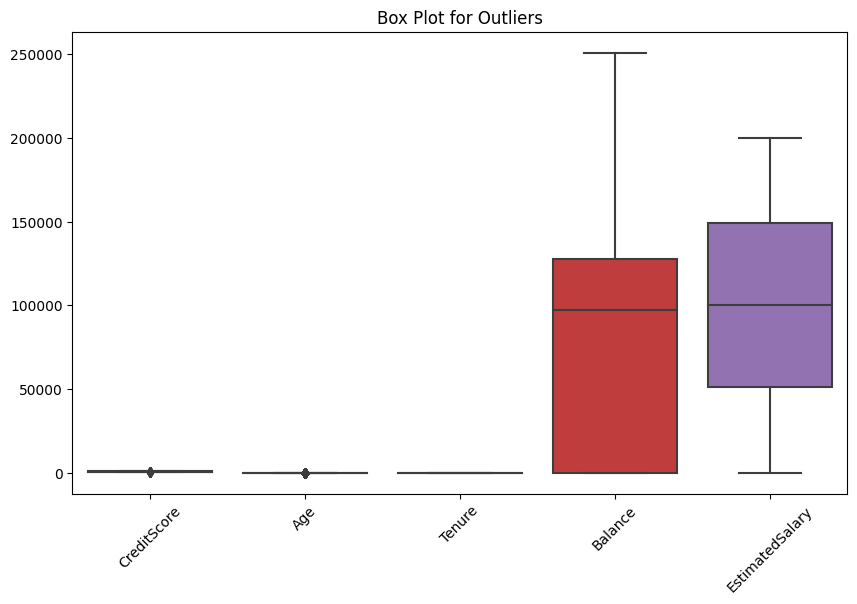

In [26]:
columns_to_plot = ['CreditScore', 'Age','Tenure','Balance','EstimatedSalary']
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[columns_to_plot])
plt.title('Box Plot for Outliers')
plt.xticks(rotation=45)
plt.show()

In [31]:
len(df)

10000

In [29]:
q1 = df['Balance'].quantile(0.25)
q3 = df['Balance'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_no_outliers = df[(df['Balance'] >= lower_bound) & (df['Balance'] <= upper_bound)]

In [30]:
q1 = df['EstimatedSalary'].quantile(0.25)
q3 = df['EstimatedSalary'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_no_outliers = df[(df['EstimatedSalary'] >= lower_bound) & (df['EstimatedSalary'] <= upper_bound)]

In [33]:
len(df_no_outliers)

10000

In [34]:
df['credit_score_tf'] = df['CreditScore'].apply(lambda x: 25*round(x/25))
df['age_tf'] = df['Age'].apply(lambda x: 5*round(x/5))
df['log10_balance'] = df['Balance'].apply(lambda x: 1/5*round(5*np.log10(x+1)))
df['log10_estimated_salary'] = df['EstimatedSalary'].apply(lambda x: 1/2*round(2*np.log10(x)))

df.drop(["EstimatedSalary","Age","CreditScore","Balance"],axis=1,inplace=True)
df

,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,credit_score_tf,age_tf,log10_balance,log10_estimated_salary
CustomerId,,,,,,,,,,,
15634602,France,Female,2,1,1,1,1,625,40,0.0,5.0
15647311,Spain,Female,1,1,0,1,0,600,40,5.0,5.0
15619304,France,Female,8,3,1,0,1,500,40,5.2,5.0
15701354,France,Female,1,2,0,0,0,700,40,0.0,5.0
15737888,Spain,Female,2,1,1,1,0,850,45,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...
15606229,France,Male,5,2,1,0,0,775,40,0.0,5.0
15569892,France,Male,10,1,1,1,0,525,35,4.8,5.0
15584532,France,Female,7,1,0,1,1,700,35,0.0,4.5


In [35]:
st = StandardScaler()
dff = pd.get_dummies(df,columns=cols[0])

In [36]:
dff[['credit_score_tf','age_tf', 'log10_balance', 'log10_estimated_salary']] = st.fit_transform(dff[['credit_score_tf','age_tf', 'log10_balance', 'log10_estimated_salary']])

In [37]:
c1 = [x for x in dff.columns if str(dff[x].dtype) == 'int64']
c2 = [x for x in dff.columns if str(dff[x].dtype) == 'float64']
c1,c2

(['Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited'],
 ['credit_score_tf', 'age_tf', 'log10_balance', 'log10_estimated_salary'])

<Axes: >

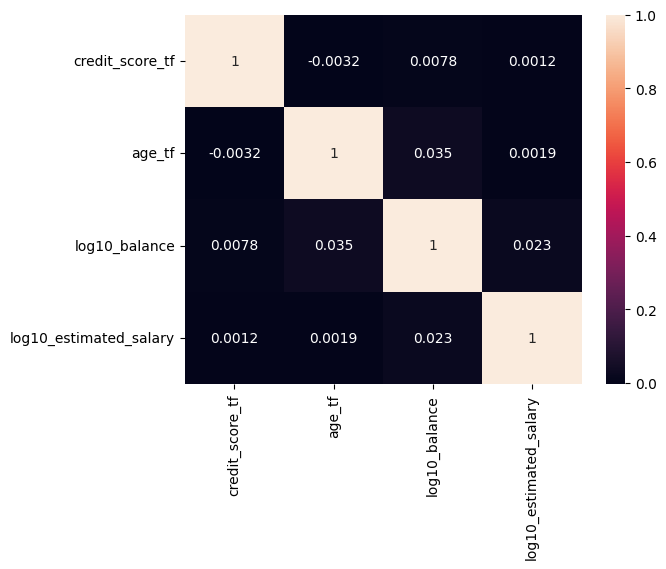

In [38]:
sns.heatmap(dff[c2].corr(),annot=True)

<Axes: >

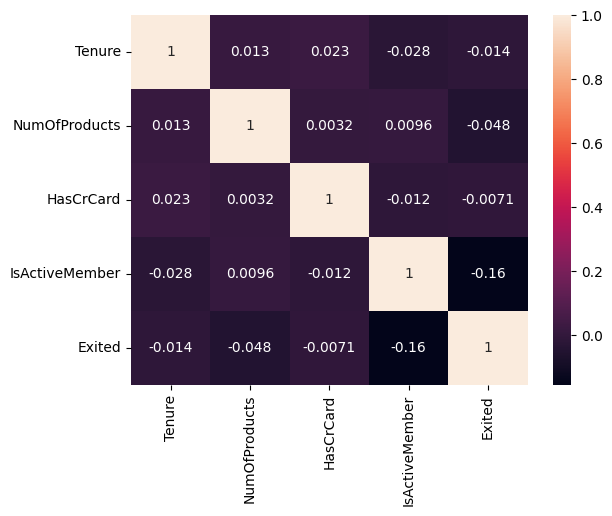

In [39]:
sns.heatmap(dff[c1].corr(),annot=True)

<Axes: >

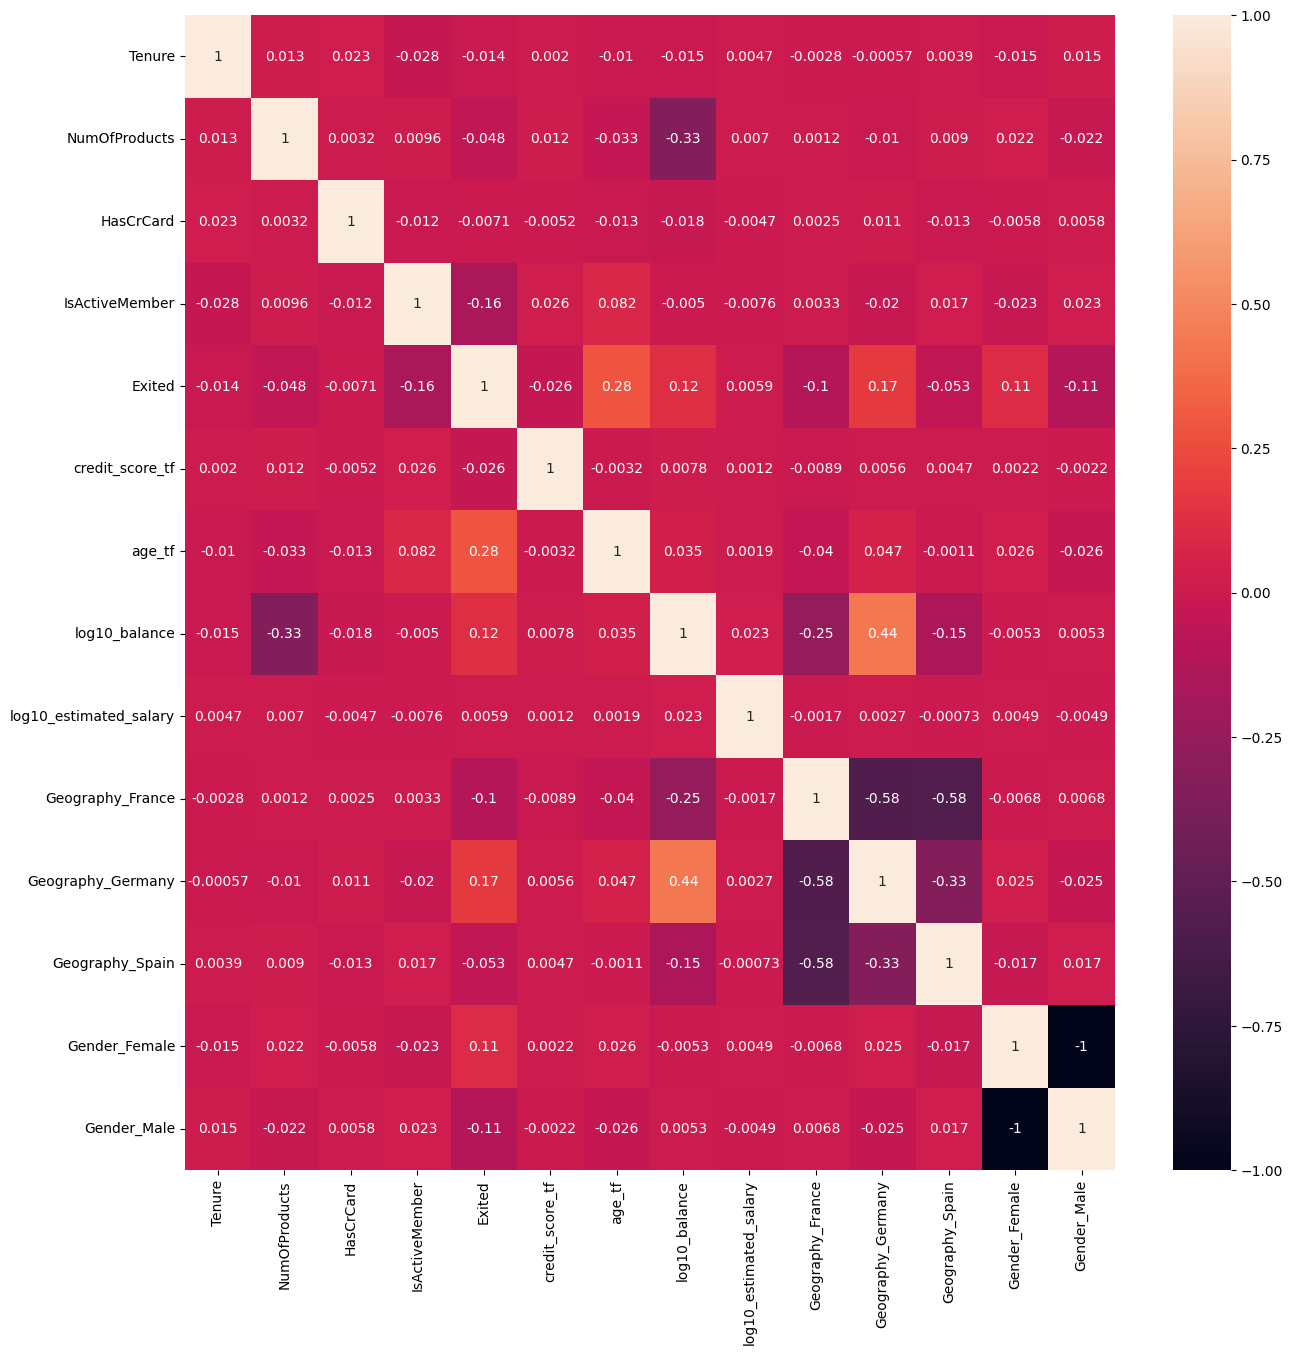

In [40]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(dff.corr(),annot=True,ax=ax)

In [47]:
X = dff[c1].drop('Exited',axis=1)
y = df.Exited

In [48]:
from sklearn.feature_selection import chi2
chi_vals = chi2(X, y)
chi = pd.Series(chi_vals[0],index=c1.remove('Exited'))
p = pd.Series(chi_vals[1],index=c1)

<BarContainer object of 4 artists>

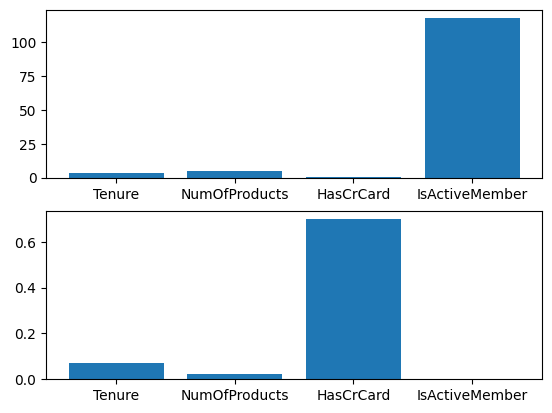

In [49]:
f, ax = plt.subplots(2,1)
ax[0].bar(x=c1,height=chi)
ax[1].bar(x=c1,height=p)

In [51]:
comp = [3,6,9]
exp_var = {}
for i in comp:
  pca = PCA(n_components=i)
  pca.fit_transform(dff)
  exp_var[i] = pca.explained_variance_ratio_

In [52]:
exp_var

{3: array([0.5792    , 0.07918898, 0.06972369]),
 6: array([0.5792    , 0.07918898, 0.06972369, 0.06912547, 0.06849547,
        0.0345216 ]),
 9: array([0.5792    , 0.07918898, 0.06972369, 0.06912547, 0.06849547,
        0.0345216 , 0.02522458, 0.02060659, 0.01793117])}

In [53]:
dff.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64